## SOTorch using L2 

This code retrieves a surface map from reflection integrated light curve of an Earth analog.

See 
- Kawahara & Fujii 2010 (http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1004.5152)
- Kawahara & Fujii 2011 (http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1106.0136)
- Fujii & Kawahara 2012 (http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1204.3504)

for more details.  

You need Healpy and pytorch.  Install by 

``pip install healpy``

for instance.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import healpy as hp
import pylab 
import matplotlib.pyplot as plt
import time
import torch
import torch.optim as optim

In [4]:
#vectors and weight
def comp_omega(nside):
    omega=[]    
    npix=hp.nside2npix(nside)
    print("npix=",npix)
    for ipix in range(0,npix):
        theta,phi=hp.pix2ang(nside,ipix)
        omega.append([theta,phi])            
    return np.array(omega)

def uniteO(inc,Thetaeq):
    #(3)
    eO=np.array([np.sin(inc)*np.cos(Thetaeq),-np.sin(inc)*np.sin(Thetaeq),np.cos(inc)])
    return eO

def uniteS(Thetaeq,Thetav):
    #(3,nsamp)
    eS=np.array([np.cos(Thetav-Thetaeq),np.sin(Thetav-Thetaeq),np.zeros(len(Thetav))])
    return eS

def uniteR(zeta,Phiv,omega):
    #(3,nsamp,npix)    
    np.array([Phiv]).T
    costheta=np.cos(omega[:,0])
    sintheta=np.sin(omega[:,0])
    cosphiPhi=np.cos(omega[:,1]+np.array([Phiv]).T)
    sinphiPhi=np.sin(omega[:,1]+np.array([Phiv]).T)
    x=cosphiPhi*sintheta
    y=np.cos(zeta)*sinphiPhi*sintheta+np.sin(zeta)*costheta
    z=-np.sin(zeta)*sinphiPhi*sintheta+np.cos(zeta)*costheta
    eR=np.array([x,y,z])

    return eR

def comp_weight(nside,zeta,inc,Thetaeq,Thetav,Phiv):
    omega=comp_omega(nside)
    eO=uniteO(inc,Thetaeq)
    eS=uniteS(Thetaeq,Thetav)
    eR=uniteR(zeta,Phiv,omega)
    WV=[]
    for ir in range(0, np.shape(eS)[1]):
        ele=np.dot(eR[:,ir,:].T,eO)
        WV.append(ele)
    WV=np.array(WV)
    mask=(WV<0.0)
    WV[mask]=0.0
    WI=[]
    for ir in range(0, np.shape(eS)[1]):
        ele=np.dot(eR[:,ir,:].T,eS[:,ir])
        WI.append(ele)
    WI=np.array(WI)
    mask=(WI<0.0)
    WI[mask]=0.0

    return WI,WV

In [5]:
#set geometry
inc=0.0
Thetaeq=np.pi
zeta=np.pi/3.0
                                                                                                
Pspin=23.9344699/24.0 #Pspin: a sidereal day                                                                                                                                                                                                               
wspin=2*np.pi/Pspin                                                                                                          
#Porb=365.242190402                                            
Porb=40.0
worb=2*np.pi/Porb                                                                                                                
N=1024
obst=np.linspace(0.0,Porb,N)

NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


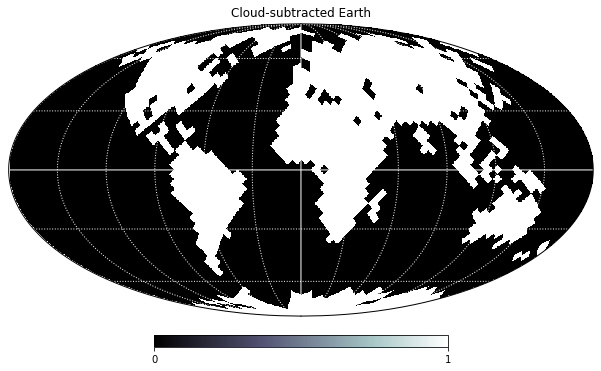

In [6]:
# test map
nside=16
mmap=hp.read_map("../../data/mockalbedo16.fits")
mask=(mmap>0.0)
mmap[mask]=1.0
hp.mollview(mmap, title="Cloud-subtracted Earth",flip="geo",cmap=plt.cm.bone,min=0,max=1)
#hp.mollview(Kvolall,title="Kvol",flip="geo",cmap=plt.cm.Spectral,min=-0.3,max=0.3)
hp.graticule(color="white");
M=len(mmap)

In [7]:
Thetav=worb*obst
Phiv=np.mod(wspin*obst,2*np.pi)
WI,WV=comp_weight(nside,zeta,inc,Thetaeq,Thetav,Phiv)
W=WV[:,:]*WI[:,:]
lc=np.dot(W,mmap)

sigma=np.mean(lc)*0.03
noise=np.random.normal(0.0,sigma,len(lc))
lc=lc+noise

npix= 3072


No handles with labels found to put in legend.


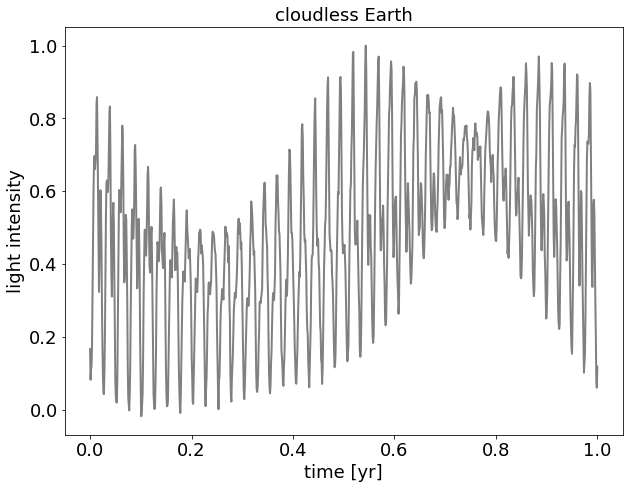

In [8]:
fig= plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
ax.plot(obst/obst[-1],lc/np.max(lc),lw=2,color="gray")
plt.legend(loc="upper right",prop={'size':11},frameon=False)
plt.tick_params(labelsize=18)
plt.ylabel("light intensity",fontsize=18)
plt.xlabel("time [yr]",fontsize=18)
plt.title("cloudless Earth",fontsize=18)
plt.savefig("sotlc.png", bbox_inches="tight", pad_inches=0.0)
plt.show()


In [17]:
m=torch.randn(np.shape(mmap), requires_grad = True)

In [18]:
Wt=torch.from_numpy(W).float() 
lct=torch.from_numpy(lc)
lam=1.0
Q = torch.sum((lct - torch.mv(Wt,m))**2) + lam*torch.sum(m*m)

In [19]:
Q.backward()

In [20]:
print(Q)

tensor(5005058.0147, dtype=torch.float64, grad_fn=<AddBackward0>)


In [21]:
op = optim.Adam([m],lr=0.01)

In [31]:
for i in range(0,10000):
    Q = torch.sum((lct - torch.mv(Wt,m))**2) + lam*torch.sum(m*m)
    op.zero_grad()
    Q.backward()
    op.step()
    

In [32]:
print(m)

tensor([ 4.6094e-01,  2.8851e-01,  3.7537e-02,  ..., -1.2612e-44,
         3.2230e-44,  5.6052e-45], requires_grad=True)


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


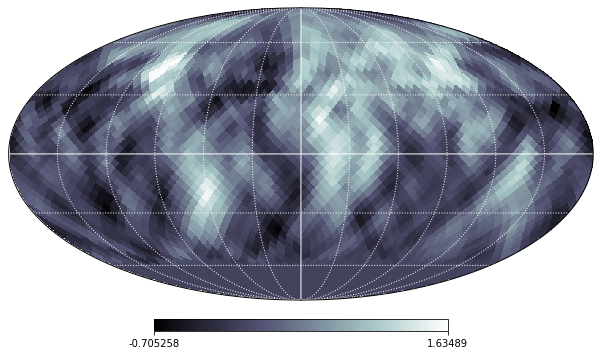

In [33]:
mnp=m.detach().numpy()
hp.mollview(mnp, title="",flip="geo",cmap=plt.cm.bone)
hp.graticule(color="white");